# Panoptic Segmentation

2D scene understanding

In [1]:
# Step1: Setup and Installation
!pip install -q transformers torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.8 MB/s eta 0:00:00


In [2]:
import torch
from transformers import Mask2FormerForUniversalSegmentation, AutoImageProcessor
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
# Step 2: Load the model and processor
# The processor handles all the preprocessing: resizing, normalizing etc
# The 'model' is the powerful Mask2Former architecture with pre trained weights.
# We are using a model fine tuned on COCO panoptic segmentation dataset

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-coco-panoptic")


In [7]:
# Step 3: Load and prepare the Image
image_path = "streets.jpg"
image = Image.open(image_path).convert("RGB")

# Process the image to get the pixel values in the right format for the model
inputs = processor(images=image, return_tensors="pt")

# Step 4: Perform Inference
# We run the model and get the segmentation results
with torch.no_grad():
  outputs = model(**inputs)

# Post-process the output to get the final panoptic segmentation map
# The 'target_sizes' argument ensures the mask is resized to our original image dimensions.
panoptic_result = processor.post_process_panoptic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
panoptic_map = panoptic_result["segmentation"]
segments_info = panoptic_result["segments_info"]

`label_ids_to_fuse` unset. No instance will be fused.


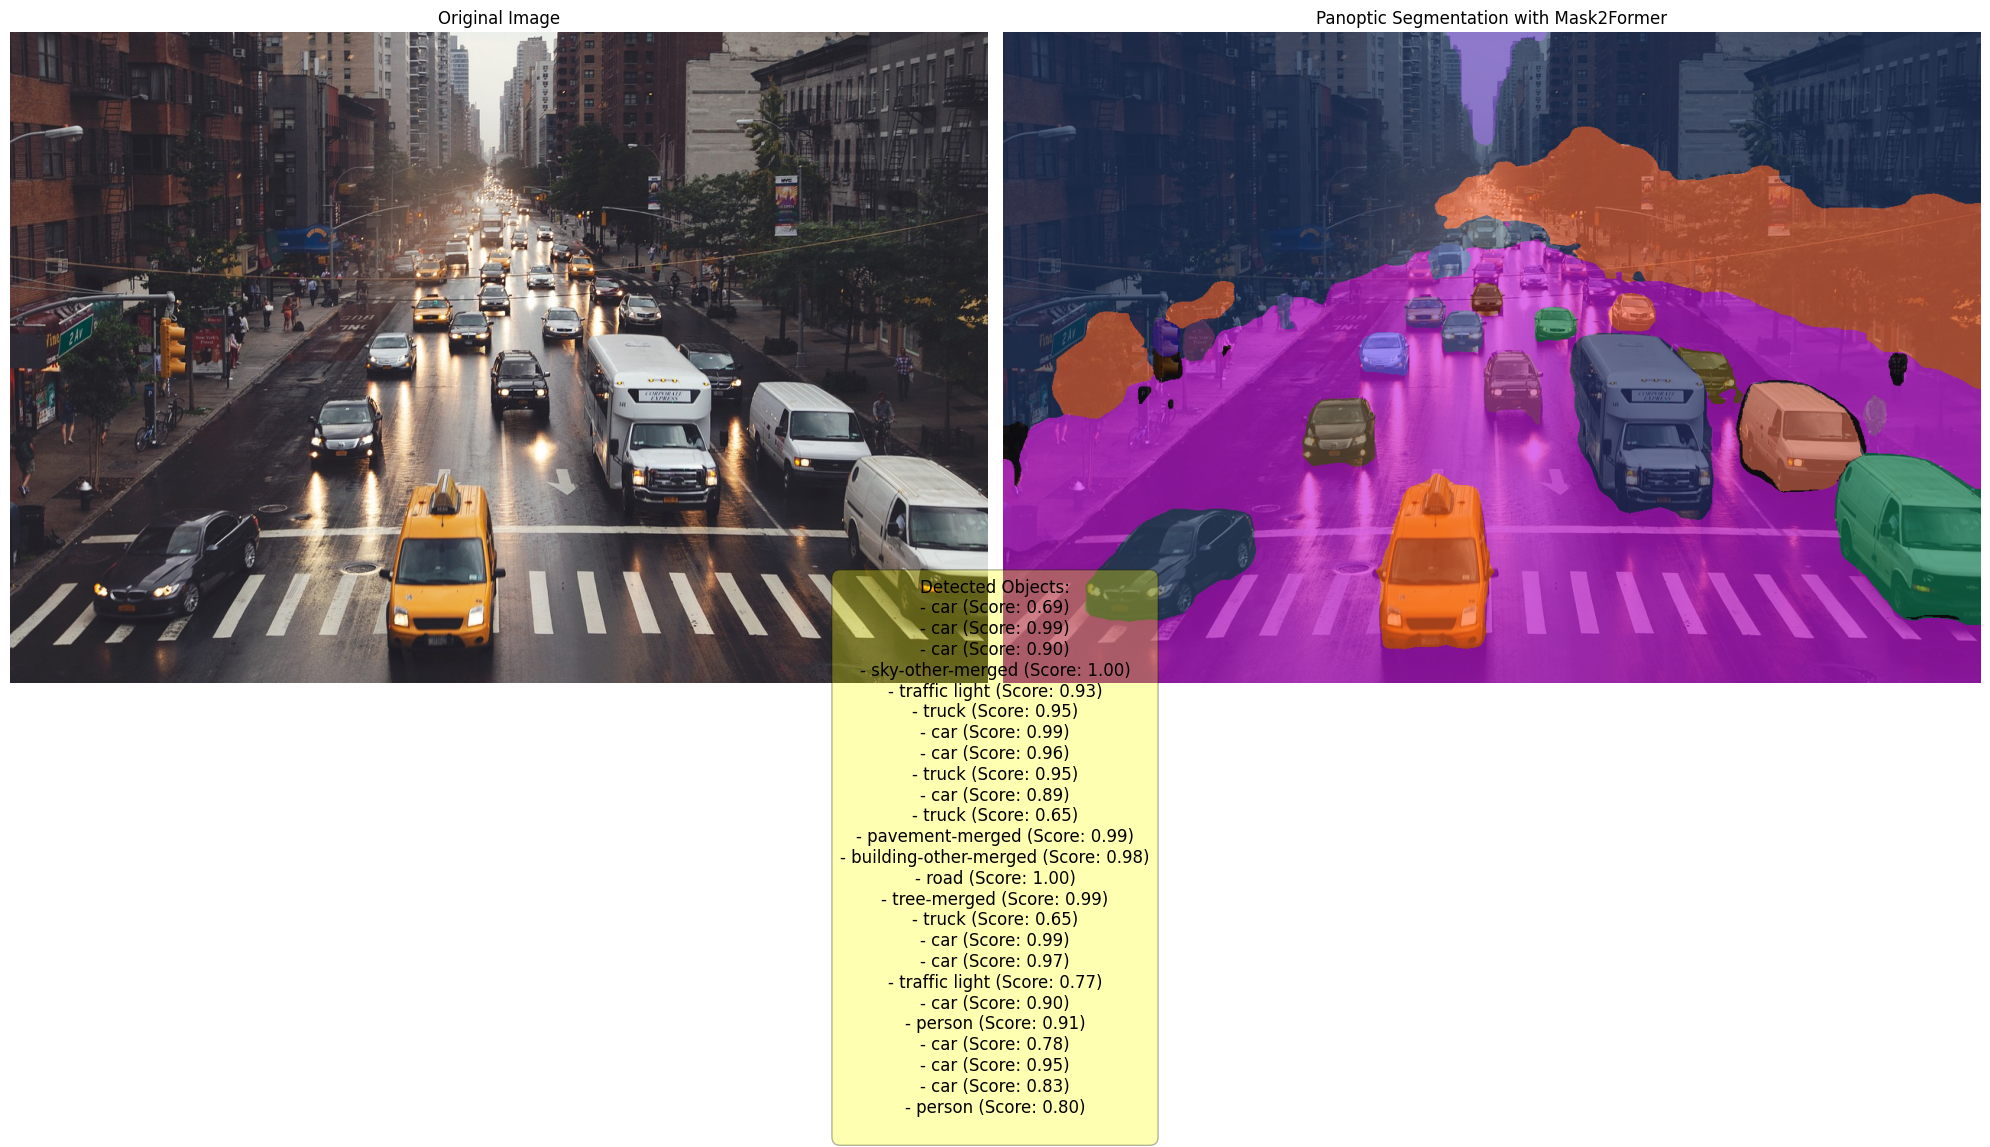

In [8]:
# Step 5: Visualization
# Function to draw the masks on top of original image
def draw_panoptic_segmentation(panoptic_map, segments_info):
  # Create a blank canvas to draw the colored masks on
  height, width = panoptic_map.shape
  colored_mask = np.zeros((height, width, 3), dtype=np.uint8)

  # Define a random color palette for different categories
  color_map = {}

  for segment in segments_info:
    segment_id = segment['id']
    color = (random.randint(0,255), random.randint(0,127), random.randint(0,255))
    color_map[segment_id] = color

  # Color each pixel according to its segment ID
  for y in range(height):
    for x in range(width):
      segment_id = panoptic_map[y,x].item()
      if segment_id in color_map:
        colored_mask[y,x] = color_map[segment_id]
  return colored_mask

# Draw the masks
colored_segmentation = draw_panoptic_segmentation(panoptic_map, segments_info)

# Overlay the masks onto the original image with transparency
# This creates the classic segmentation visual.
alpha = 0.6
overlay_image = Image.fromarray((np.array(image) * (1 - alpha) + colored_segmentation * alpha).astype(np.uint8))

# Display the final image
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(overlay_image)
ax[1].set_title("Panoptic Segmentation with Mask2Former")
ax[1].axis('off')

# Add a legend to explain what was found
legend_text = "Detected Objects:\n"
for segment in segments_info:
    label = model.config.id2label[segment['label_id']]
    # For "things", the model gives a score. For "stuff", it doesn't.
    score_text = f" (Score: {segment['score']:.2f})" if 'score' in segment else ""
    legend_text += f"- {label}{score_text}\n"

# Place the legend text on the plot
fig.text(0.5, 0.05, legend_text, ha='center', va='center', wrap=True, fontsize=12, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.3))

plt.tight_layout(rect=[0, 0.1, 1, 1]) # Adjust layout to make space for the text
plt.show()

In [9]:
from collections import defaultdict

# Use a defaultdict to easily count instances of each category
instance_counts = defaultdict(int)

# Loop through the information for each detected segment
for segment in segments_info:
    # Get the human-readable label for the segment
    label = model.config.id2label[segment['label_id']]

    # The model's output for "things" (countable objects like cars, people)
    # includes a confidence score. "Stuff" (like road, sky) usually does not.
    # This is a reliable way to filter for only the objects we want to count.
    if 'score' in segment:
        instance_counts[label] += 1

# Print the final counts in a clean format
print("Scene Census:")
print("-----------------")
if not instance_counts:
    print("No countable objects found.")
else:
    for label, count in instance_counts.items():
        print(f"- {label.capitalize()}: {count}")


Scene Census:
-----------------
- Car: 12
- Sky-other-merged: 1
- Traffic light: 2
- Truck: 4
- Pavement-merged: 1
- Building-other-merged: 1
- Road: 1
- Tree-merged: 1
- Person: 2
